##FD schemes convergece investigation using 2D wave equation

In [1]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import Indexed
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from fdlib import *
init_printing()

In [2]:
U,V,Txx,Tyy,Txy = IndexedBases('U V Txx Tyy Txy')
beta, lam, mu = symbols('beta lambda mu')
x,y,t,t1,h,dt,a,b, Vs, dimx, dimy, xx, yy = symbols('x y t t1 h dt a b Vs dimx dimy xx yy')

In [3]:
accuracy_time = 1 # O(dt^2) accuracy in time domain
accuracy_space = 2 # O(h^4) accuracy in space domain
hf = Rational(1,2) #1/2

###Eigenmode functions (as initial condition and analytical solution)

$U = acos(\pi x)sin(\pi y)cos(at)$<br>
$V = -asin(\pi x)cos(\pi y)cos(at)$<br>
$T_{xx} = -bsin(\pi x)sin(\pi y)sin(at)$<br>
$T_{yy} = bsin(\pi x)sin(\pi y)sin(at)$<br>
$T_{xy} = T_{yx} = 0$<br>
where $a=\sqrt 2 \pi V_s\space \space b=2\pi\mu$

In [4]:
a = 2**(0.5)*pi*Vs
b = 2*pi*mu
U_sol = a*cos(pi*xx)*sin(pi*yy)*cos(a*t)
V_sol = -a*sin(pi*xx)*cos(pi*yy)*cos(a*t)
Txx_sol = -b*sin(pi*xx)*sin(pi*yy)*sin(a*t)
Tyy_sol = b*sin(pi*xx)*sin(pi*yy)*sin(a*t)
Txy_sol = Float(0)

###Initial conditions

In [5]:
# substitution t=0
U_init_code = print_myccode(U[0,x,y])+'='+print_myccode(U_sol.subs(t,dt/2))
V_init_code = print_myccode(V[0,x,y])+'='+print_myccode(V_sol.subs(t,dt/2))
Txx_init_code = print_myccode(Txx[0,x,y])+'='+print_myccode(Txx_sol.subs(t,0))
Tyy_init_code = print_myccode(Tyy[0,x,y])+'='+print_myccode(Tyy_sol.subs(t,0))
Txy_init_code = print_myccode(Txy[0,x,y])+'='+print_myccode(Txy_sol.subs(t,0))

###Calculate FD approximation of derivatives

In [6]:
l = [t,x,y]

# first-order time derivatives in velocities and stresses
# O(dt^2) accuracy
DtU = Deriv_half_2(U,l,0,dt,accuracy_time)[1]
DtV = Deriv_half_2(V,l,0,dt,accuracy_time)[1]

DtTxx = Deriv_half_2(Txx,l,0,dt,accuracy_time)[1]
DtTxy = Deriv_half_2(Txy,l,0,dt,accuracy_time)[1]
DtTyy = Deriv_half_2(Tyy,l,0,dt,accuracy_time)[1]

# first-order spacial derivatives of velocities and stresses
# O(h^4) accuracy

DxU = Deriv_half_2(U,l,1,h,accuracy_space)[1]
DyV = Deriv_half_2(V,l,2,h,accuracy_space)[1]

DyU = Deriv_half_2(U,l,2,h,accuracy_space)[1]
DxV = Deriv_half_2(V,l,1,h,accuracy_space)[1]

DxTxx = Deriv_half_2(Txx,l,1,h,accuracy_space)[1]
DyTyy = Deriv_half_2(Tyy,l,2,h,accuracy_space)[1]

DxTxy = Deriv_half_2(Txy,l,1,h,accuracy_space)[1]
DyTxy = Deriv_half_2(Txy,l,2,h,accuracy_space)[1]

In [7]:
DxTxx

In [8]:
DtTxy

In [9]:
DyTxy

###PDEs

#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda\partial_yV $<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda\partial_xU $<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>

In [10]:
# momentum equations
eq1 = Eq(DtU, beta*(DxTxx + DyTxy)).subs(x,x+hf)
eq2 = Eq(DtV, beta*(DxTxy + DyTyy)).subs(y,y+hf)

# stress-strain equations
eq3 = Eq(DtTxx, (lam + 2*mu)*DxU + lam*DyV)
eq4 = Eq(DtTyy, (lam + 2*mu)*DyV + lam*DxU)
eq5 = Eq(DtTxy, mu*(DyU+DxV)).subs({x:x+hf,y:y+hf})

In [11]:
eq5

In [12]:
eq3

###solve for FD stencil

In [13]:
# for demo only
# note replacing t-half whith t
U_t = simplify(solve(eq1,U[t+hf,x+hf,y])[0]-U[t-hf,x+hf,y]).subs(t,t1)+U[t,x+hf,y]
V_t = simplify(solve(eq2,V[t+hf,x,y+hf])[0]-V[t-hf,x,y+hf]).subs(t,t1)+V[t,x,y+hf]
Txx_t = simplify(solve(eq3,Txx[t+hf,x,y])[0]-Txx[t-hf,x,y])+Txx[t,x,y]
Tyy_t = simplify(solve(eq4,Tyy[t+hf,x,y])[0]-Tyy[t-hf,x,y])+Tyy[t,x,y]
# note difference between Txx and Txy indices
Txy_t = simplify(solve(eq5,Txy[t+hf,x+hf,y+hf])[0]-Txy[t-hf,x+hf,y+hf])+Txy[t,x+hf,y+hf]

In [14]:
Txy_t

In [15]:
# generate computation code segments
U_t_code = print_myccode(U[t1,x,y]) + "=" + print_myccode(shift_grid(U_t))
V_t_code = print_myccode(V[t1,x,y]) + "=" + print_myccode(shift_grid(V_t))
Txx_t_code = print_myccode(Txx[t1,x,y]) + "=" + print_myccode(shift_grid(Txx_t))
Tyy_t_code = print_myccode(Tyy[t1,x,y]) + "=" + print_myccode(shift_grid(Tyy_t))
Txy_t_code = print_myccode(Txy[t1,x,y]) + "=" + print_myccode(shift_grid(Txy_t))

In [16]:
# they look like this
U_t_code

'U[t1][x][y]=(1.0F/24.0F)*beta*dt*(-27*Txx[t1][x][y] + Txx[t1][x - 1][y] + 27*Txx[t1][x + 1][y] - Txx[t1][x + 2][y] + 27*Txy[t1][x][y] + Txy[t1][x][y - 2] - 27*Txy[t1][x][y - 1] - Txy[t1][x][y + 1])/h + U[t][x][y]'

In [17]:
# and this
Txy_t_code

'Txy[t1][x][y]=(1.0F/24.0F)*dt*mu*(-27*U[t][x][y] + U[t][x][y - 1] + 27*U[t][x][y + 1] - U[t][x][y + 2] - 27*V[t][x][y] + V[t][x - 1][y] + 27*V[t][x + 1][y] - V[t][x + 2][y])/h + Txy[t][x][y]'

##boundary conditions

###get the second order FD approximation in space

In [18]:
l = [t1,x,y]

# first-order spacial derivatives of velocities
# O(h^2) accuracy
DxU2 = Deriv_half_2(U,l,1,h,1)[1]
DyV2 = Deriv_half_2(V,l,2,h,1)[1]
DyU2 = Deriv_half_2(U,l,2,h,1)[1]
DxV2 = Deriv_half_2(V,l,1,h,1)[1]

# these are used to calculate U and V beyond boundary
Txx_expr = (lam + 2*mu)*DxU2 + lam*DyV2
Tyy_expr = (lam + 2*mu)*DyV2 + lam*DxU2
Txy_expr = mu*(DyU2 + DxV2)

###at boundary $y=2$
$T_{xx}[x,2]=0$<br>
$T_{yy}[x,2]=0$<br>
Txx not needed beyond the boundary<br>
$T_{xx}[x,1]=-T_{xx}[x,3]$<br>
$T_{yy}[x,1]=-T_{yy}[x,3]$<br>
$T_{xy}[x,3/2]=-T_{xy}[x,5/2]$<br>
$T_{xy}[x,1/2]=-T_{xy}[x,7/2]$<br>

In [19]:
U_t.subs(y,2)

In [20]:
V_t.subs(y,2+hf)

In [21]:
Txx_t.subs(y,3)

In [22]:
Tyy_t.subs(y,3)

In [23]:
Txy_t.subs(y,2+hf)

###### to calculate above, we need these point beyond the boundary
$T_{xy}[x,\frac{1}{2}] = -T_{xy}[x,\frac{7}{2}]$<br>
$T_{xy}[x,\frac{3}{2}] = -T_{xy}[x,\frac{5}{2}]$<br>
$T_{yy}[x,1] = -T_{yy}[x,3]$<br>
$U[x,1]$<br>
$V[x,\frac{3}{2}]$<br>

####calculate $V[x,\frac{3}{2}]$

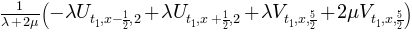

In [24]:
bc_V_y0 = solve(Tyy_expr.subs(y,2), V[t1,x,1+hf])[0]; bc_V_y0

####calculate $U[x,1]$

In [25]:
bc_U_y0 = solve(Eq(Txy_expr.subs({x:x+hf,y:1+hf}), -Txy_expr.subs({x:x+hf,y:2+hf})),U[t1,x+hf,1])[0]; bc_U_y0

In [26]:
U_y0 = U[t1,x+hf,1]
V_y0 = V[t1,x,1+hf]
bc_V_y0_code = print_myccode(shift_grid(V_y0))+'='+print_myccode(shift_grid(bc_V_y0))
bc_U_y0_code = print_myccode(shift_grid(U_y0))+'='+print_myccode(shift_grid(bc_U_y0))

###at boundary $y=dimy-3$
$T_{xx}[x,dimy-3]=0$<br>
$T_{yy}[x,dimy-3]=0$<br>
Txx not needed beyond the boundary<br>
$T_{xx}[x,dimy-2]=-T_{xx}[x,dimy-4]$<br>
$T_{yy}[x,dimy-2]=-T_{yy}[x,dimy-4]$<br>
$T_{xy}[x,dimy-5/2]=-T_{xy}[x,dimy-7/2]$<br>
$T_{xy}[x,dimy-3/2]=-T_{xy}[x,dimy-9/2]$<br>

In [27]:
U_t.subs(y,dimy-3)

In [28]:
V_t.subs(y,dimy-3-hf)

In [29]:
Txx_t.subs(y,dimy-4)

In [30]:
Tyy_t.subs(y,dimy-4)

In [31]:
Txy_t.subs(y,dimy-3-hf)

###### to calculate above, we need these point beyond the boundary
$T_{xy}[x,dimy-\frac{5}{2}] = -T_{xy}[x,dimy-\frac{7}{2}]$<br>
$T_{xy}[x,dimy-\frac{3}{2}] = -T_{xy}[x,dimy-\frac{9}{2}]$<br>
$T_{yy}[x,dimy-2] = -T_{yy}[x,dimy-4]$<br>
$U[x,dimy-2]$<br>
$V[x,dimy-\frac{5}{2}]$<br>

####calculate $V[x,dimy-\frac{5}{2}]$

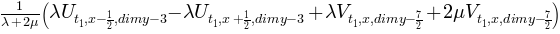

In [32]:
V_y1 = V[t1,x,dimy-2-hf]
bc_V_y1 = solve(Tyy_expr.subs(y,dimy-3), V_y1)[0]; bc_V_y1

####calculate $U[x+\frac{1}{2},dimy-2]$

In [33]:
U_y1 = U[t1,x+hf,dimy-2]
bc_U_y1 = solve(Eq(Txy_expr.subs({x:x+hf,y:dimy-2-hf}), -Txy_expr.subs({x:x+hf,y:dimy-3-hf})),U_y1)[0]; bc_U_y1

In [34]:
bc_V_y1_code = print_myccode(shift_grid(V_y1))+'='+print_myccode(shift_grid(bc_V_y1))
bc_U_y1_code = print_myccode(shift_grid(U_y1))+'='+print_myccode(shift_grid(bc_U_y1))

In [35]:
U_x0 = U[t1,1+hf,y]
V_x0 = V[t1,1,y+hf]
bc_U_x0 = solve(Tyy_expr.subs(x,2), U_x0)[0]
bc_V_x0 = solve(Eq(Txy_expr.subs({x:1+hf,y:y+hf}), -Txy_expr.subs({x:2+hf,y:y+hf})),V_x0)[0]

In [36]:
bc_V_x0_code = print_myccode(shift_grid(V_x0))+'='+print_myccode(shift_grid(bc_V_x0))
bc_U_x0_code = print_myccode(shift_grid(U_x0))+'='+print_myccode(shift_grid(bc_U_x0))

In [37]:
U_x1 = U[t1,dimx-2-hf,y]
V_x1 = V[t1,dimx-2,y+hf]
bc_U_x1 = solve(Tyy_expr.subs(x,dimx-3), U_x1)[0]
bc_V_x1 = solve(Eq(Txy_expr.subs({x:dimx-2-hf,y:y+hf}), -Txy_expr.subs({x:dimx-3-hf,y:y+hf})),V_x1)[0]

In [38]:
bc_V_x1_code = print_myccode(shift_grid(V_x1))+'='+print_myccode(shift_grid(bc_V_x1))
bc_U_x1_code = print_myccode(shift_grid(U_x1))+'='+print_myccode(shift_grid(bc_U_x1))

In [39]:
bc_init_V_x0_code = print_myccode(shift_grid(V_x0).subs(t1,0))+'='+print_myccode(shift_grid(bc_V_x0).subs(t1,0))
bc_init_U_x0_code = print_myccode(shift_grid(U_x0).subs(t1,0))+'='+print_myccode(shift_grid(bc_U_x0).subs(t1,0))
bc_init_V_x1_code = print_myccode(shift_grid(V_x1).subs(t1,0))+'='+print_myccode(shift_grid(bc_V_x1).subs(t1,0))
bc_init_U_x1_code = print_myccode(shift_grid(U_x1).subs(t1,0))+'='+print_myccode(shift_grid(bc_U_x1).subs(t1,0))
bc_init_V_y0_code = print_myccode(shift_grid(V_y0).subs(t1,0))+'='+print_myccode(shift_grid(bc_V_y0).subs(t1,0))
bc_init_U_y0_code = print_myccode(shift_grid(U_y0).subs(t1,0))+'='+print_myccode(shift_grid(bc_U_y0).subs(t1,0))
bc_init_V_y1_code = print_myccode(shift_grid(V_y1).subs(t1,0))+'='+print_myccode(shift_grid(bc_V_y1).subs(t1,0))
bc_init_U_y1_code = print_myccode(shift_grid(U_y1).subs(t1,0))+'='+print_myccode(shift_grid(bc_U_y1).subs(t1,0))

###output using templates

In [40]:
# write to template file
mylookup = TemplateLookup(directories=['templates/'])
mytemplate = mylookup.get_template('ref_converge_tmpl.cpp')
buf = StringIO()
dict1 = {'time_period':2,'Txx':Txx_t_code,'Tyy':Tyy_t_code,'Txy':Txy_t_code,'U':U_t_code,'V':V_t_code}
dict1.update({'bc_U_x0':bc_U_x0_code,'bc_U_x1':bc_U_x1_code,'bc_U_y0':bc_U_y0_code,'bc_U_y1':bc_U_y1_code})
dict1.update({'bc_V_x0':bc_V_x0_code,'bc_V_x1':bc_V_x1_code,'bc_V_y0':bc_V_y0_code,'bc_V_y1':bc_V_y1_code})
dict1.update({'U_init':U_init_code,'V_init':V_init_code})
dict1.update({'Txx_init':Txx_init_code,'Tyy_init':Tyy_init_code,'Txy_init':Txy_init_code})
dict1.update({'bc_init_U_x0':bc_init_U_x0_code,'bc_init_U_x1':bc_init_U_x1_code,'bc_init_U_y0':bc_init_U_y0_code,'bc_init_U_y1':bc_init_U_y1_code})
dict1.update({'bc_init_V_x0':bc_init_V_x0_code,'bc_init_V_x1':bc_init_V_x1_code,'bc_init_V_y0':bc_init_V_y0_code,'bc_init_V_y1':bc_init_V_y1_code})
#dict1.update({'bc_Txx_x0':bc_Txx_x0_code,'bc_Txx_x1':bc_Txx_x1_code,'bc_Txx_y0':bc_Txx_y0_code,'bc_Txx_y1':bc_Txx_y1_code})
#dict1.update({'bc_Tyy_x0':bc_Tyy_x0_code,'bc_Tyy_x1':bc_Tyy_x1_code,'bc_Tyy_y0':bc_Tyy_y0_code,'bc_Tyy_y1':bc_Tyy_y1_code})
#dict1.update({'bc_Txy_x0':bc_Txy_x0_code,'bc_Txy_x1':bc_Txy_x1_code,'bc_Txy_y0':bc_Txy_y0_code,'bc_Txy_y1':bc_Txy_y1_code})
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)
code = buf.getvalue()

In [41]:
# generate compilable C++ source code
f= open('../tests/src/ref_converge.cpp','w')
f.write(code)
f.close()